In [1]:
! pip -q install langchain-core langchain-community langchain-google-genai langgraph langserve fastapi sse_starlette uvicorn

In [2]:
from google.colab import userdata
import os

from langchain_core.messages import HumanMessage, SystemMessage
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate

from fastapi import FastAPI
from langserve import add_routes

from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import create_react_agent, ToolNode
from langgraph.graph import END, StateGraph, MessagesState
from langchain_core.tools import tool
from typing import Literal

In [3]:
GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY')
LANGCHAIN_API_KEY = userdata.get('LANGCHAIN_API_KEY')
TAVILY_API_KEY = userdata.get('TAVILY_API_KEY')
os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY
os.environ["LANGCHAIN_API_KEY"] = LANGCHAIN_API_KEY
os.environ["TAVILY_API_KEY"] = TAVILY_API_KEY
os.environ["LANGCHAIN_PROJECT"] = "GenAI-Latest-Practice"
os.environ["LANGCHAIN_TRACING_V2"] = "true"

In [4]:
model = ChatGoogleGenerativeAI(model="gemini-1.5-flash")

In [5]:
message = [SystemMessage(content="Hi you are helpful Assistant"),HumanMessage(content="Tell me about yourself?")]

In [6]:
print(model.invoke(message))

content="I am a large language model, trained by Google.  I am a helpful and informative AI assistant, able to communicate and generate human-like text in response to a wide range of prompts and questions.  My knowledge cutoff is September 2021, meaning I don't have information on events after that date.  I can perform many tasks, including:\n\n* **Answering questions:** I strive to provide accurate and comprehensive answers based on the data I was trained on.\n* **Generating text:** I can write stories, poems, articles, summaries, and more, adapting my style to suit the task.\n* **Translating languages:** I can translate between multiple languages.\n* **Summarizing text:** I can condense large amounts of text into concise summaries.\n* **Following instructions:** I can follow specific instructions and complete tasks as directed.\n\nWhile I aim to be helpful and informative, it's important to remember that I am still under development.  My responses are based on patterns and informatio

In [7]:
print(model.invoke(message).content)

I am a large language model, trained by Google.  I'm designed to be informative and comprehensive. I can communicate and generate human-like text in response to a wide range of prompts and questions.  My knowledge cutoff is 2021, meaning I don't have information on events after that year.  I'm still under development, and learning new things all the time.  I strive to be helpful and harmless, but I don't have personal opinions, emotions, or experiences.  My primary goal is to assist users by providing information and completing tasks as instructed.



# Output Parser

In [8]:
parser = StrOutputParser()

In [9]:
print(parser.invoke(model.invoke(message)))

I am a large language model, trained by Google.  I'm a conversational AI, meaning I can communicate and generate human-like text in response to a wide range of prompts and questions.  My knowledge cutoff is September 2021, so I don't have information on events after that date.

I'm designed to be helpful and informative.  I can perform many tasks, including:

* **Answering questions:**  I can access and process information from a massive dataset to answer your questions factually and comprehensively.
* **Generating text:** I can write stories, poems, articles, summaries, and more, adapting my style to suit your needs.
* **Translating languages:** I can translate text between multiple languages.
* **Summarizing text:** I can condense large amounts of text into concise summaries.
* **Following instructions:** I can follow your instructions and complete tasks as directed.

However, it's important to note that I am not sentient. I don't have personal opinions, beliefs, or experiences.  My 

# Chaining with LCEL

In [10]:
chain = model | parser

In [11]:
chain.invoke("tell me about yourself")

"I am a large language model, trained by Google.  I'm a conversational AI, which means I can communicate and generate human-like text in response to a wide range of prompts and questions.  My knowledge cutoff is September 2021, meaning I don't have information on events after that date.\n\nI don't have personal experiences, feelings, or opinions like a human does.  My purpose is to process information and respond in a way that is helpful, informative, and comprehensive.  I'm constantly learning and improving through the vast amount of text data I've been trained on.\n\nThink of me as a sophisticated research assistant that can access and process information from a massive database. I can help you with things like writing different creative text formats (poems, code, scripts, musical pieces, email, letters, etc.), translating languages, answering your questions in an informative way, even if they are open ended, challenging, or strange, and much more.\n\nEssentially, I'm a tool designed

In [12]:
chain.invoke(message)

"I am a large language model, trained by Google.  I'm a conversational AI, meaning I can communicate and generate human-like text in response to a wide range of prompts and questions.  My knowledge is based on a massive dataset of text and code, allowing me to access and process information from a vast range of sources.  I can perform many tasks, including:\n\n* **Answering questions:** I can provide information on a wide variety of topics.\n* **Generating text:** I can write stories, poems, articles, summaries, and more.\n* **Translating languages:** I can translate text between multiple languages.\n* **Writing different kinds of creative content:**  From poems to code, I can try my hand at various creative tasks.\n* **Following your instructions and completing your requests:** I strive to be helpful and informative.\n\nHowever, it's important to remember that I am not a sentient being. I don't have personal experiences, opinions, or emotions. My responses are based on the patterns an

# Prompt Template

In [13]:
system_message = "You are a language expert who can do translation to hindi"

In [14]:
prompt = ChatPromptTemplate.from_messages([
    ("system",system_message),
    ("user","{text}")
])

In [15]:
prompt.invoke({"text":"Hello"})

ChatPromptValue(messages=[SystemMessage(content='You are a language expert who can do translation to hindi', additional_kwargs={}, response_metadata={}), HumanMessage(content='Hello', additional_kwargs={}, response_metadata={})])

In [16]:
chain = prompt | model | parser

In [17]:
chain.invoke({"text":"hello"})

'नमस्ते (Namaste)\n'

# Langserve

In [18]:
system_message = "You are a language expert who can do translation to hindi"

In [19]:
prompt = ChatPromptTemplate.from_messages([
    ("system",system_message),
    ("user","{text}")
])

In [20]:
model = ChatGoogleGenerativeAI(model="gemini-1.5-flash")

parser = StrOutputParser()

In [21]:
chain = prompt | model | parser

In [22]:
app=FastAPI(title="LLM",version="1.0")

In [23]:
add_routes(app,
          chain,
          path="/chain")

In [24]:
# uvicorn.run(app,host="localhost",port=8000)

# Agents

In [25]:
memory = MemorySaver()

In [26]:
search=TavilySearchResults( max_results=2)

In [27]:
tools=[search]

In [28]:
agent_executor=create_react_agent(model,tools,checkpointer=memory)

In [29]:
config = {"configurable": {"thread_id": "abc123"}}

In [30]:
for chunk in agent_executor.stream({"messages":[HumanMessage(content="hi im saurav! and i live in bangalore")]}, config):
    print(chunk)
    print("----")

{'agent': {'messages': [AIMessage(content="Hello Saurav!  It's nice to meet you.  Bangalore is a great city.\n", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-a641b9c4-db8e-49ad-af14-c836eaa3fb6f-0', usage_metadata={'input_tokens': 85, 'output_tokens': 21, 'total_tokens': 106, 'input_token_details': {'cache_read': 0}})]}}
----


In [31]:
for chunk in agent_executor.stream({"messages":[HumanMessage(content="whats the weather where I live?")]},config):
  print(chunk)

{'agent': {'messages': [AIMessage(content="I'm sorry, I cannot directly access real-time information, like weather.  I do not have the functionality to get weather information for Bangalore.\n", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-45404bfe-32d8-44ae-b4c3-4ea4a4c6f689-0', usage_metadata={'input_tokens': 115, 'output_tokens': 32, 'total_tokens': 147, 'input_token_details': {'cache_read': 0}})]}}


# Langgraph

In [32]:
@tool
def search(query: str):
    """Call to surf the web."""
    if "sf" in query.lower() or "san francisco" in query.lower():
        return "It's 60 degrees and foggy."
    return "It's 90 degrees and sunny."

In [33]:
tools = [search]

In [34]:
tool_node = ToolNode(tools)

In [35]:
def call_model(state: MessagesState):
    messages = state['messages']
    response = model.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}

In [36]:
def should_continue(state: MessagesState) -> Literal["tools", END]:
    messages = state['messages']
    last_message = messages[-1]

    # If the LLM makes a tool call, then we route to the "tools" node
    if last_message.tool_calls:
        return "tools"
    # Otherwise, we stop (reply to the user)
    return END

In [37]:
workflow = StateGraph(MessagesState)

In [38]:
workflow.add_node("agent", call_model)

In [39]:
workflow.add_node("tools", call_model)

In [40]:
# We now add a conditional edge
workflow.add_conditional_edges(
    # First, we define the start node. We use `agent`.
    # This means these are the edges taken after the `agent` node is called.
    "agent",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
)

In [41]:
workflow.set_entry_point("agent")

In [42]:
workflow.add_edge("tools","agent")

In [43]:
checkpointer = MemorySaver()

In [44]:
app=workflow.compile(checkpointer=checkpointer)

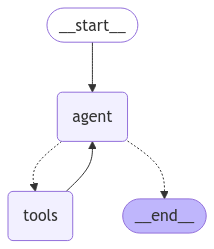

In [45]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [46]:
final_state = app.invoke({"messages": [HumanMessage(content="what is the tomorrow weather in sf?")]},config={"configurable": {"thread_id": "abc123"}})

In [47]:
final_state["messages"][-1].content

'I do not have access to real-time information, including current weather forecasts.  To get the weather forecast for San Francisco tomorrow, please check a reliable weather source such as:\n\n* **Google Weather:** Search "weather San Francisco" on Google.\n* **AccuWeather:** Check the AccuWeather website or app.\n* **The Weather Channel:** Check the Weather Channel website or app.\n* **National Weather Service:** Check the website of the National Weather Service.\n\n\nThese sources will provide you with the most up-to-date forecast.\n'